In [1]:
import warnings

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm
import scipy.special as sp
import theano

from scipy import stats
from theano import tensor as tt

%config InlineBackend.figure_format = 'retina'
warnings.simplefilter(action='ignore', category=(FutureWarning, UserWarning))
RANDOM_SEED = 8927
np.random.seed(RANDOM_SEED)

In [2]:
az.style.use("arviz-darkgrid")

# Chapter 14 - Multinomial processing trees

## 14.1 Multinomial processing model of pair-clustering
Multinomial processing trees (MPTs: Batchelder & Riefer, 1980, 1986; Chechile, 1973; Chechile & Meyer, 1976) provide one approach to modeling the finding that semantically related items are often recalled consecutively. An MPT model assumes that observed behavior arises from a sequence of cognitive events, able to be represented by a rooted tree architecture

$$ c,r,u \sim \text{Beta}(1,1)  $$
$$ \theta_{1} = cr $$
$$ \theta_{2} = (1\,-\,c)u^2 $$
$$ \theta_{3} = 2u\,(1\,-\,c)\,(1\,-\,u) $$
$$ \theta_{4} = c\,(1\,-\,r)\,+\,(1\,-\,c)\,(1\,-\,u)^2 $$
$$ \mathbf k \sim \text{Multinomial}(\mathbf \theta,n)$$

In [3]:
indiv_trial = []
Nt = 3
kall = np.array([[45, 24, 97, 254], [106, 41, 107, 166], [243, 64, 65, 48]])

kshared = theano.shared(kall[0, :])

In [4]:
with pm.Model() as model1:
    c = pm.Beta("c", alpha=1, beta=1)
    r = pm.Beta("r", alpha=1, beta=1)
    u = pm.Beta("u", alpha=1, beta=1)

    t1 = c * r
    t2 = (1 - c) * (u ** 2)
    t3 = 2 * u * (1 - c) * (1 - u)
    t4 = c * (1 - r) + (1 - c) * (1 - u) ** 2

    kobs = pm.Multinomial("kobs", p=[t1, t2, t3, t4], n=kshared.sum(), observed=kshared)

In [5]:
with model1:
    indiv_trial.append(pm.sample())

kshared.set_value(kall[1, :])
with model1:
    indiv_trial.append(pm.sample(tune=2000))

kshared.set_value(kall[2, :])
with model1:
    indiv_trial.append(pm.sample())

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [u, r, c]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [u, r, c]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 3 seconds.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [u, r, c]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


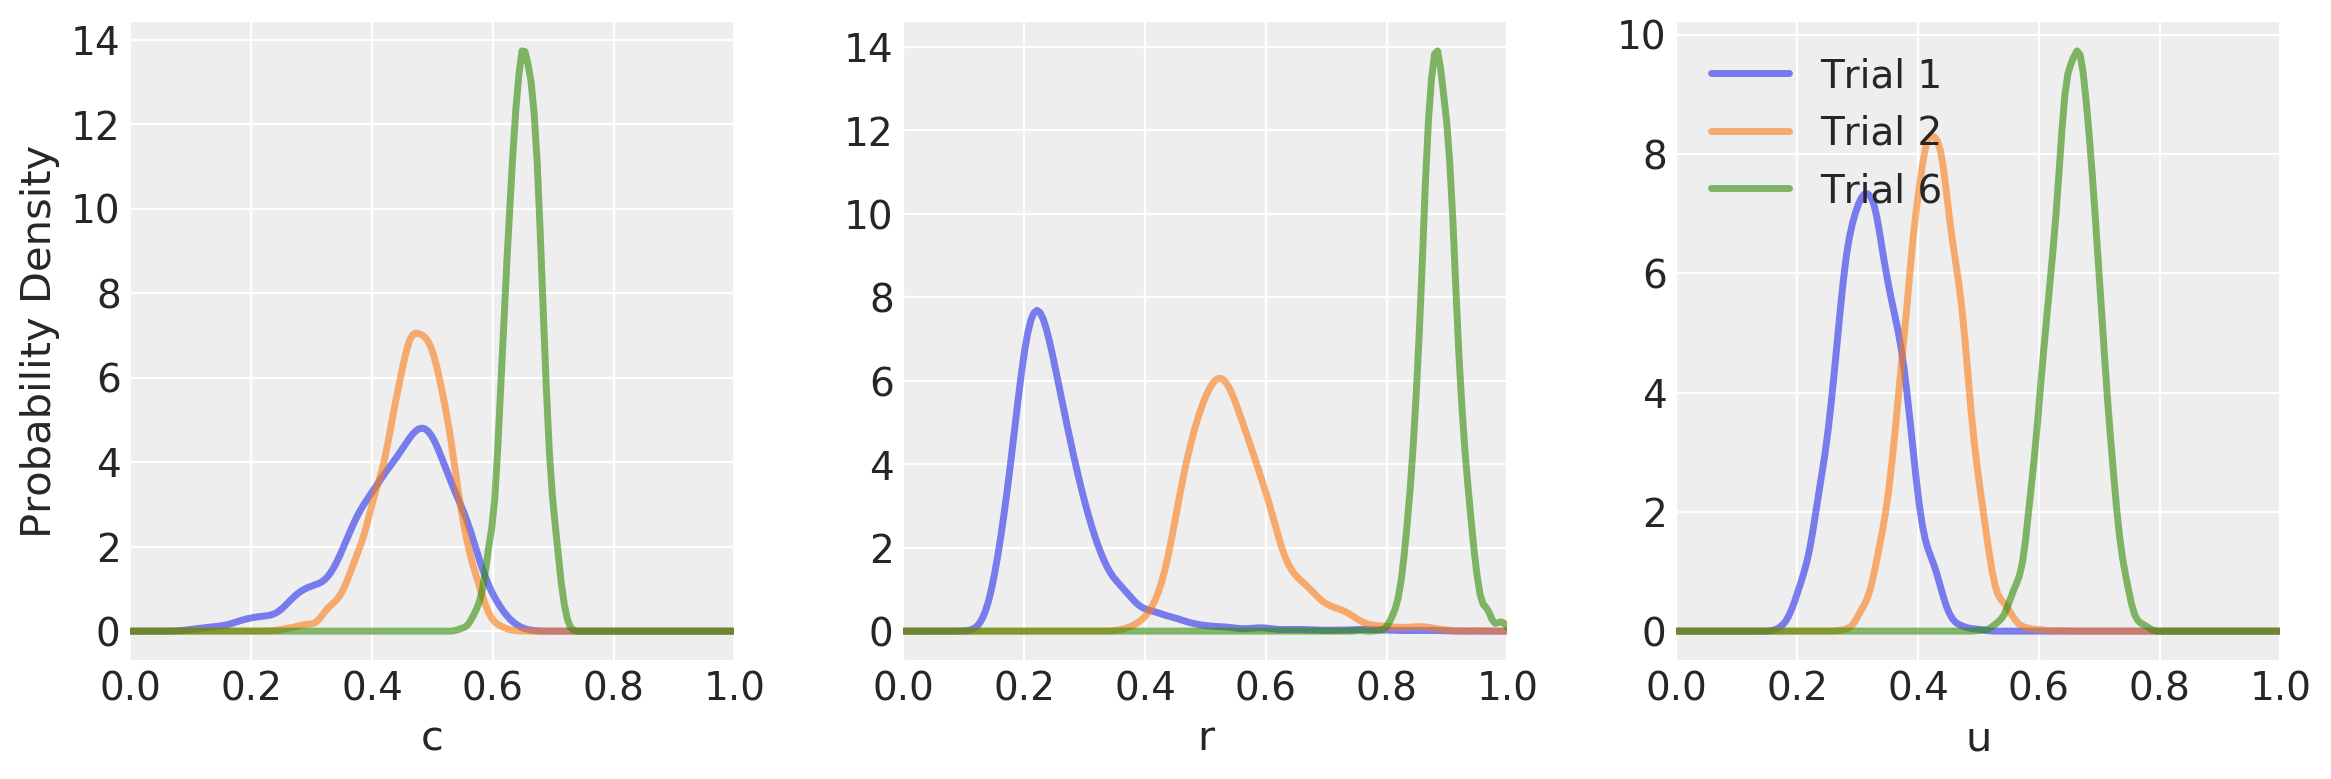

In [6]:
_, axes = plt.subplots(1, 3, figsize=(12, 4))

x1 = np.linspace(0, 1, 200)
plotparm = ["c", "r", "u"]
trialname = ["Trial 1", "Trial 2", "Trial 6"]

for trial in np.arange(Nt):
    for ip, ii in enumerate(plotparm):
        cpost = indiv_trial[trial][ii]
        my_pdf = stats.kde.gaussian_kde(cpost)
        # distribution function
        axes[ip].plot(x1, my_pdf(x1), lw=2.5, alpha=0.6)
        axes[ip].set_xlim([0, 1])
        axes[ip].set_xlabel(ii)

axes[0].set_ylabel("Probability Density")
plt.legend(trialname, loc="upper left")
plt.tight_layout();

## 14.2 Latent-trait MPT model

$$ \hat \mu^c, \hat \mu^r, \hat \mu^u \sim \text{Gaussian}(0,1)$$
$$ \hat \xi^c, \hat \xi^r, \hat \xi^u \sim \text{Uniform}(0,100)$$
$$ \Sigma^{-1} \sim \text{Wishart}(I,4)$$
$$ (\hat \delta_{i}^c,\hat \delta_{i}^r,\hat \delta_{i}^u) \sim \text{MvGaussian}(0,\Sigma^{-1})$$
$$ c_{i} = \Phi(\hat \mu^c\,+\,\hat \xi^c\hat \delta_{i}^c)$$
$$ r_{i} = \Phi(\hat \mu^r\,+\,\hat \xi^r\hat \delta_{i}^r)$$
$$ u_{i} = \Phi(\hat \mu^u\,+\,\hat \xi^u\hat \delta_{i}^u)$$
$$ \theta_{i1} = c_i r_i $$
$$ \theta_{i2} = (1\,-\,c_i)u_i^2 $$
$$ \theta_{i3} = 2u_i\,(1\,-\,c_i)\,(1\,-\,u_i) $$
$$ \theta_{i4} = c_i\,(1\,-\,r_i)\,+\,(1\,-\,c_i)\,(1\,-\,u_i)^2 $$
$$ \mathbf k_i \sim \text{Multinomial}(\mathbf \theta_i,n)$$

In [7]:
### Riefer et al (2002) data:
Nsubj = 21
Nitem = 20

response_1=np.array([2,4,4,10,2,1,3,14,2,2,5,11,6,0,4,10,1,
                     0,4,15,1,0,2,17,1,2,4,13,4,1,6,9,5,1,4,
                     10,1,0,9,10,5,0,3,12,0,1,6,13,1,5,7,7,1,
                     1,4,14,2,2,3,13,2,1,5,12,2,0,6,12,1,0,5,
                     14,2,1,8,9,3,0,2,15,1,2,3,14]).reshape(21,-1)
response_2=np.array([7,5,3,5,5,2,3,10,6,2,7,5,9,4,2,5,2,2,7,
                     9,1,3,3,13,5,0,5,10,7,3,4,6,7,3,6,4,4,1,
                     10,5,9,1,2,8,3,1,6,10,3,5,9,3,2,0,6,12,
                     8,0,3,9,3,2,7,8,7,1,5,7,2,1,6,11,5,3,5,
                     7,5,0,6,9,6,2,2,10]).reshape(21,-1)
response_6=np.array([14,3,1,2,12,3,1,4,18,0,1,1,15,3,0,2,7,
                     1,10,2,3,6,11,0,8,4,3,5,17,1,1,1,13,4,
                     3,0,11,6,1,2,16,1,2,1,10,1,3,6,7,13,0,
                     0,8,4,3,5,16,1,1,2,5,4,7,4,15,0,5,0,6,
                     3,6,5,17,2,0,1,17,1,0,2,8,3,6,3]).reshape(21,-1)

kall = [response_1, response_2, response_6]

In [8]:
p = 3
nu = p + 2
Nt = 3


def Phi(x):
    # probit transform
    return 0.5 + 0.5 * pm.math.erf(x / pm.math.sqrt(2))


kshared = theano.shared(kall[0])

In [9]:
with pm.Model() as model2:
    mu = pm.Normal("mu", mu=0, sd=1, shape=p)
    xi = pm.Uniform("xi", lower=0, upper=100, shape=p)

    wishart = pm.WishartBartlett("wishart", S=np.eye(p), nu=nu)
    cov = tt.nlinalg.matrix_inverse(wishart)

    delta = pm.MvNormal("delta", mu=np.zeros(Nt), cov=cov, shape=(Nsubj, p))

    c = Phi(mu[0] + xi[0] * delta[:, 0])
    r = Phi(mu[1] + xi[1] * delta[:, 1])
    u = Phi(mu[2] + xi[2] * delta[:, 2])

    t1 = c * r
    t2 = (1 - c) * (u ** 2)
    t3 = 2 * u * (1 - c) * (1 - u)
    t4 = c * (1 - r) + (1 - c) * (1 - u) ** 2

    muc = pm.Deterministic("muc", Phi(mu[0]))
    mur = pm.Deterministic("mur", Phi(mu[1]))
    muu = pm.Deterministic("muu", Phi(mu[2]))

    p_ = tt.stack([t1, t2, t3, t4])
    # Multinomial data likelihood
    kobs = pm.Multinomial("kobs", p=p_.T, n=Nitem, observed=kshared)

Added new variable wishart_c to model diagonal of Wishart.
Added new variable wishart_z to model off-diagonals of Wishart.


In [10]:
indiv_trial2 = []

with model2:
    indiv_trial2.append(
        pm.sample(2000, tune=2000, init="adapt_diag", target_accept=0.95)
    )

kshared.set_value(kall[1])
with model2:
    indiv_trial2.append(
        pm.sample(2000, tune=2000, init="adapt_diag", target_accept=0.95)
    )

kshared.set_value(kall[2])
with model2:
    indiv_trial2.append(
        pm.sample(2000, tune=2000, init="adapt_diag", target_accept=0.95)
    )

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [delta, wishart_z, wishart_c, xi, mu]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 192 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [delta, wishart_z, wishart_c, xi, mu]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 202 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [delta, wishart_z, wishart_c, xi, mu]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 160 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.


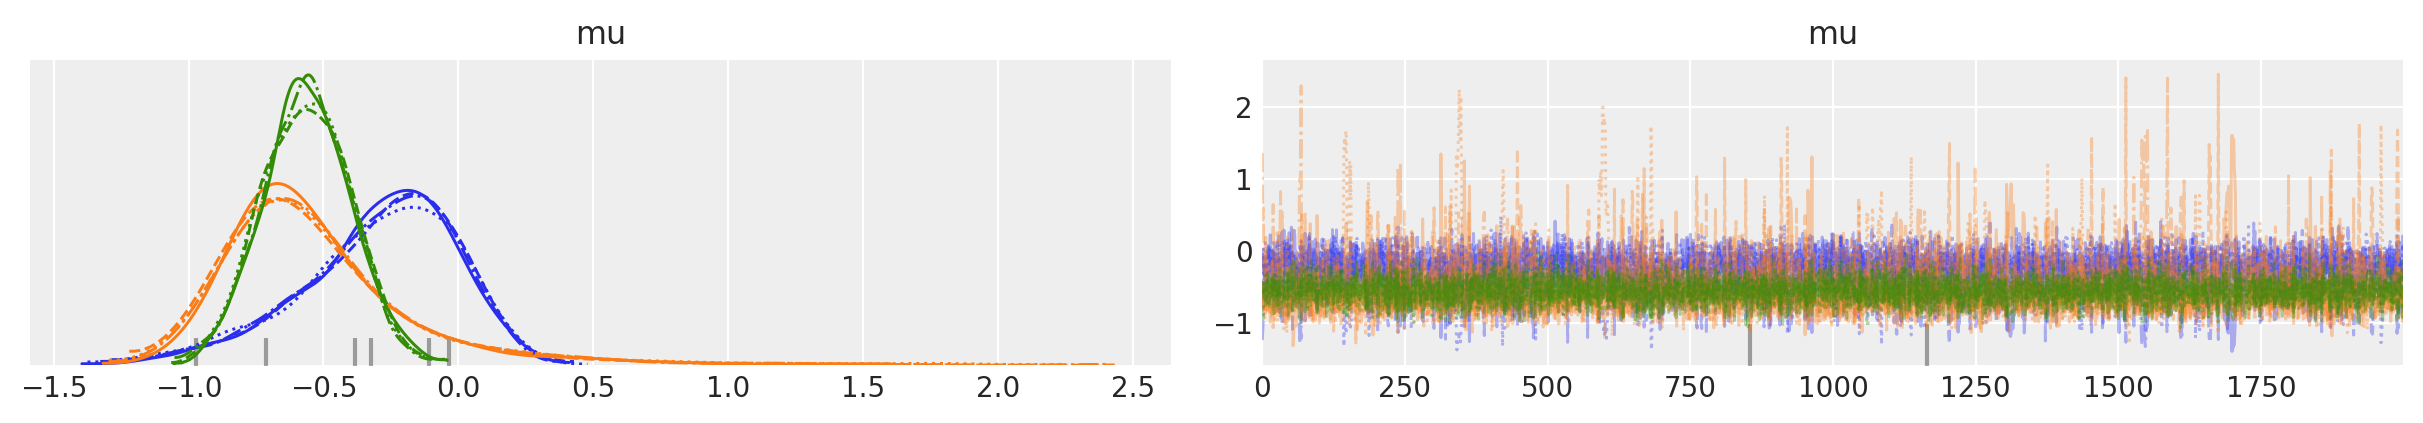

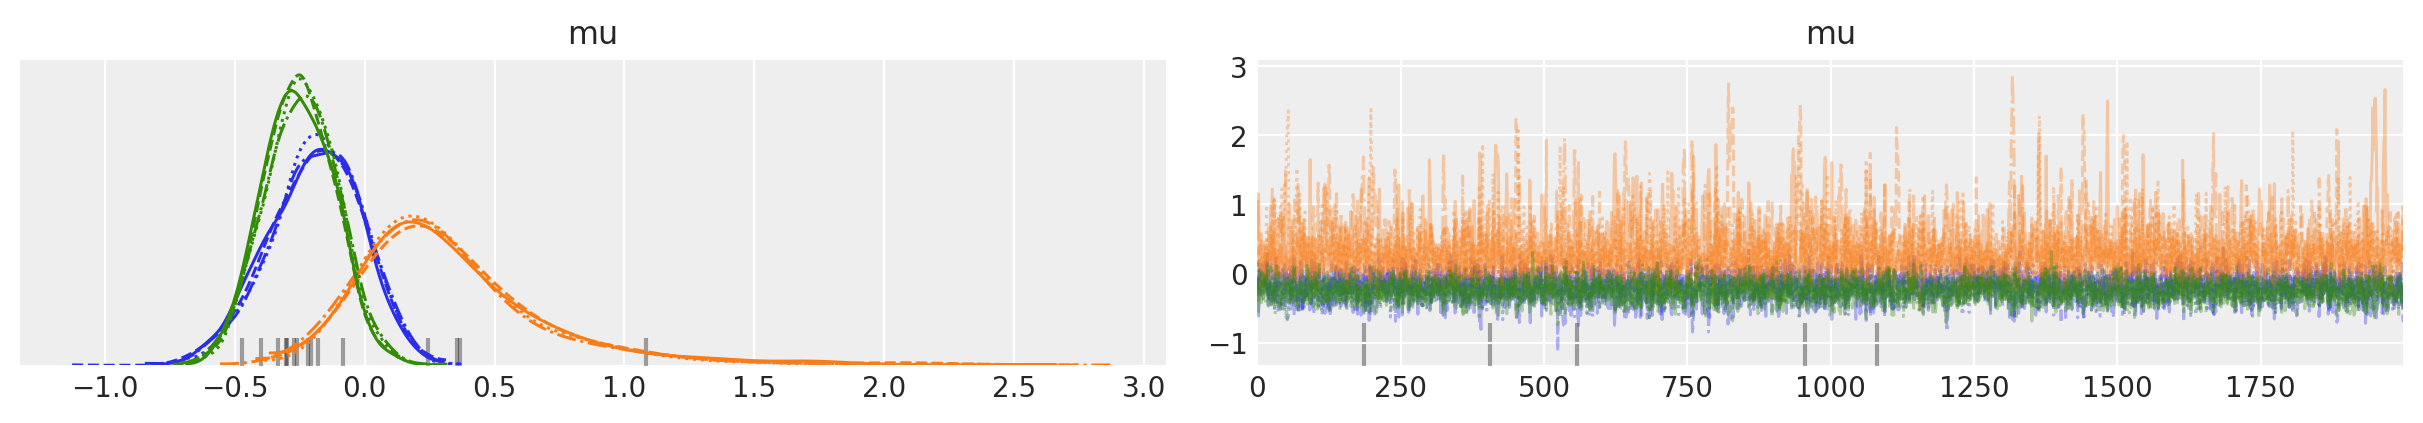

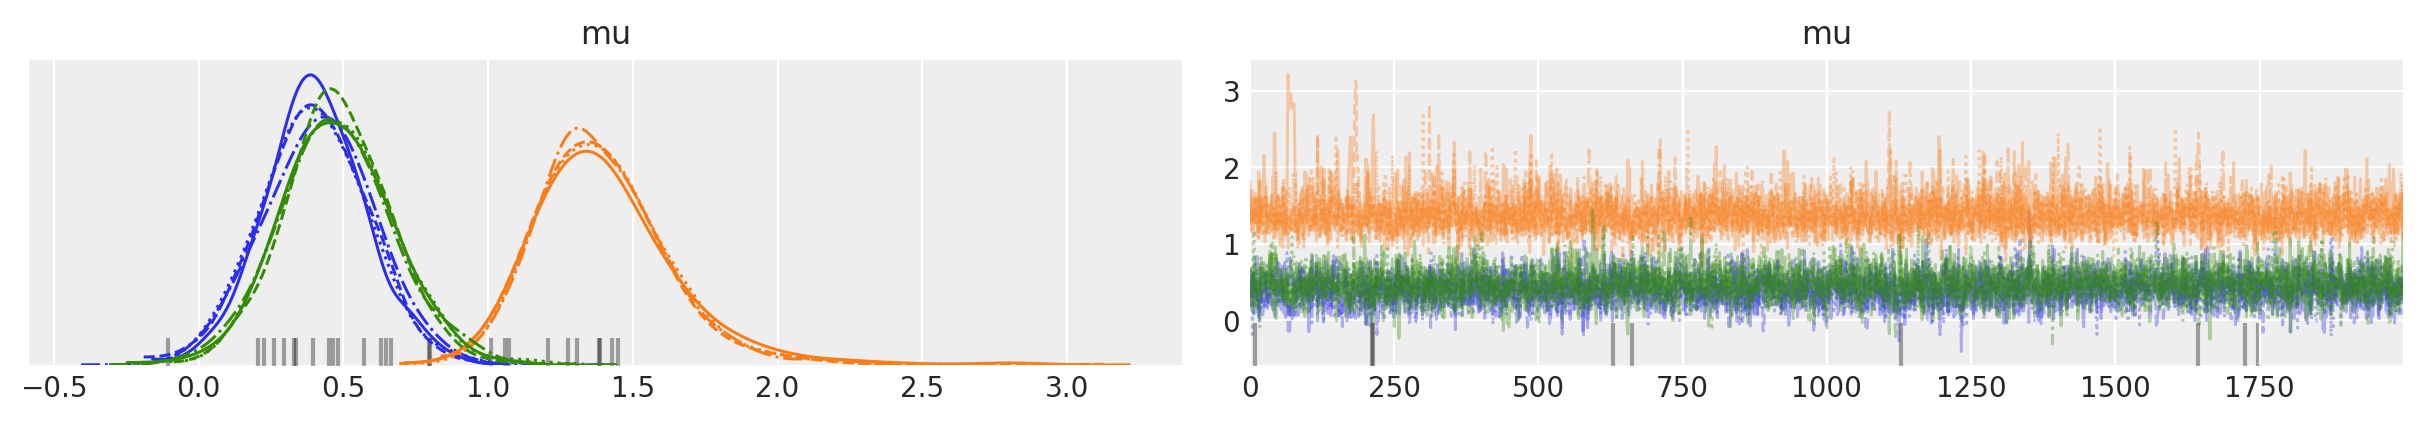

In [11]:
for trial in np.arange(Nt):
    az.plot_trace(indiv_trial2[trial], var_names=["mu"], compact=True);

In [12]:
def npPhi(x):
    # probit transform
    return (1.0 + sp.erf(x / np.sqrt(2.0))) / 2.0

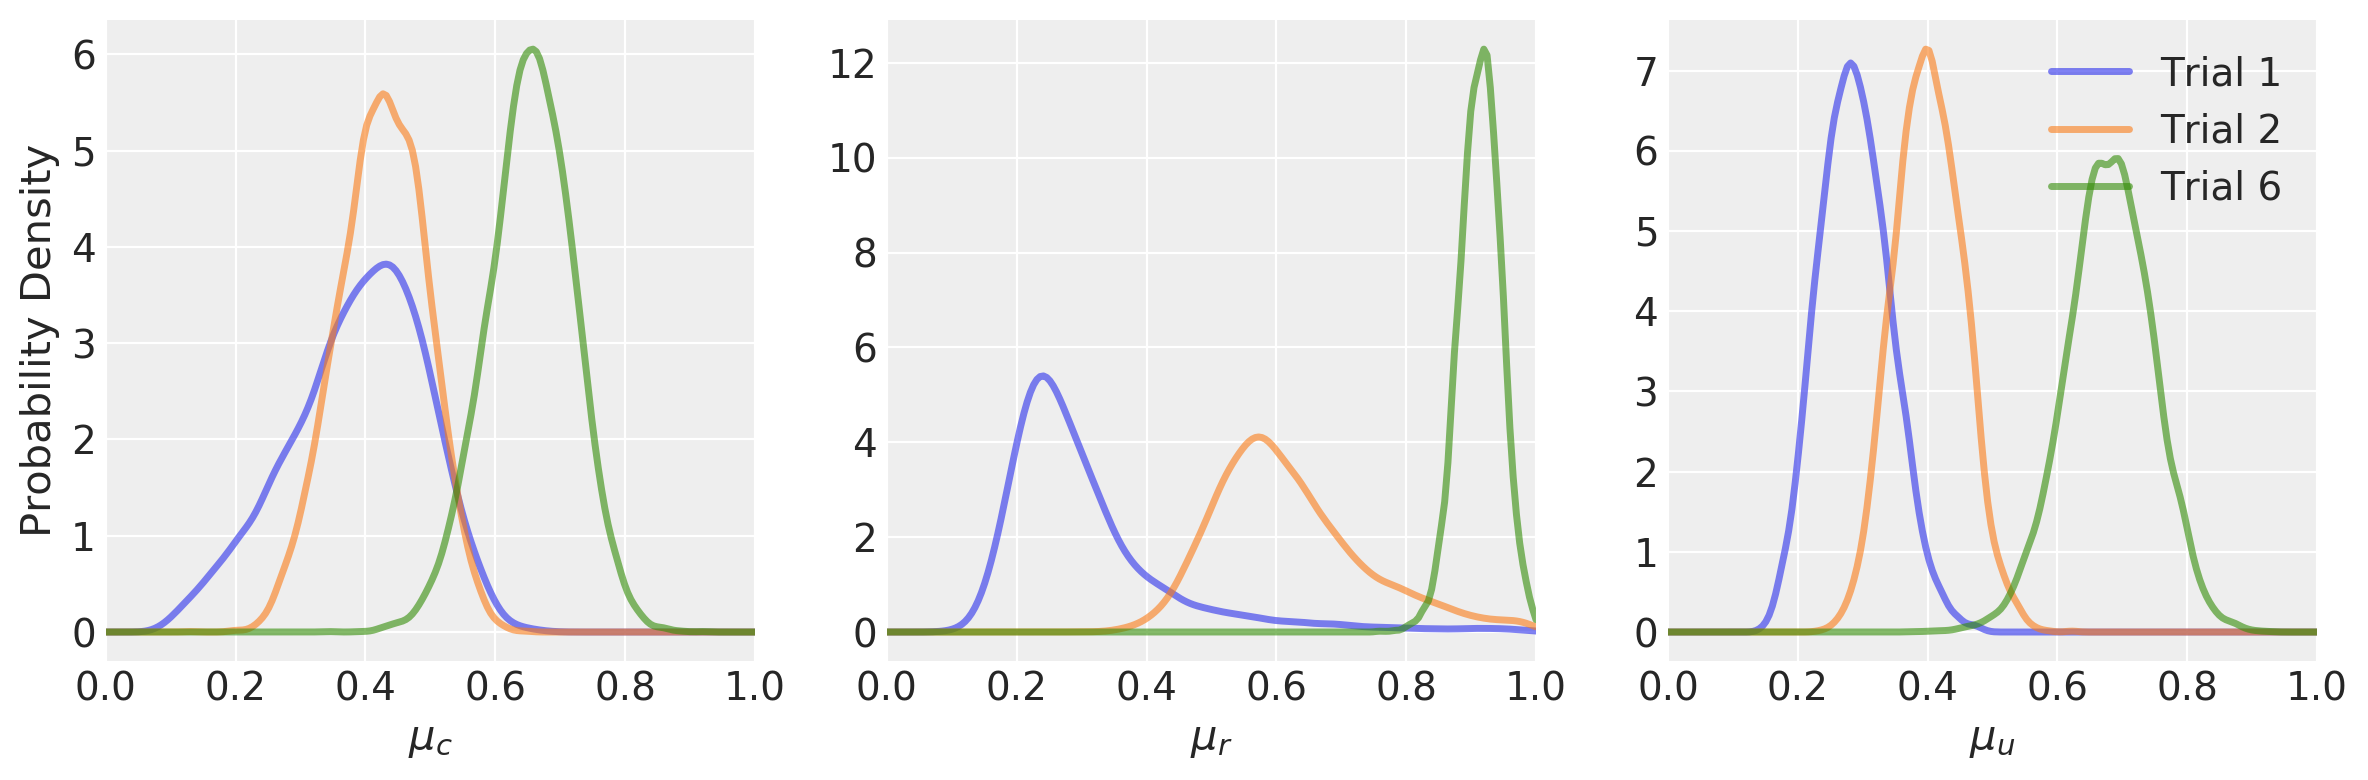

In [13]:
_, axes = plt.subplots(1, 3, figsize=(12, 4))
x1 = np.linspace(0, 1, 200)
plotparm = [r"$\mu_c$", r"$\mu_r$", r"$\mu_u$"]
trialname = ["Trial 1", "Trial 2", "Trial 6"]

for trial in np.arange(Nt):
    mupost = indiv_trial2[trial]["mu"]

    for ip, ii in enumerate(plotparm):
        cpost = npPhi(mupost[:, ip])
        my_pdf = stats.kde.gaussian_kde(cpost)
        # distribution function
        axes[ip].plot(x1, my_pdf(x1), lw=2.5, alpha=0.6)
        axes[ip].set_xlim([0, 1])
        axes[ip].set_xlabel(ii, fontsize=15)

axes[0].set_ylabel("Probability Density")
plt.legend(trialname)
plt.tight_layout();

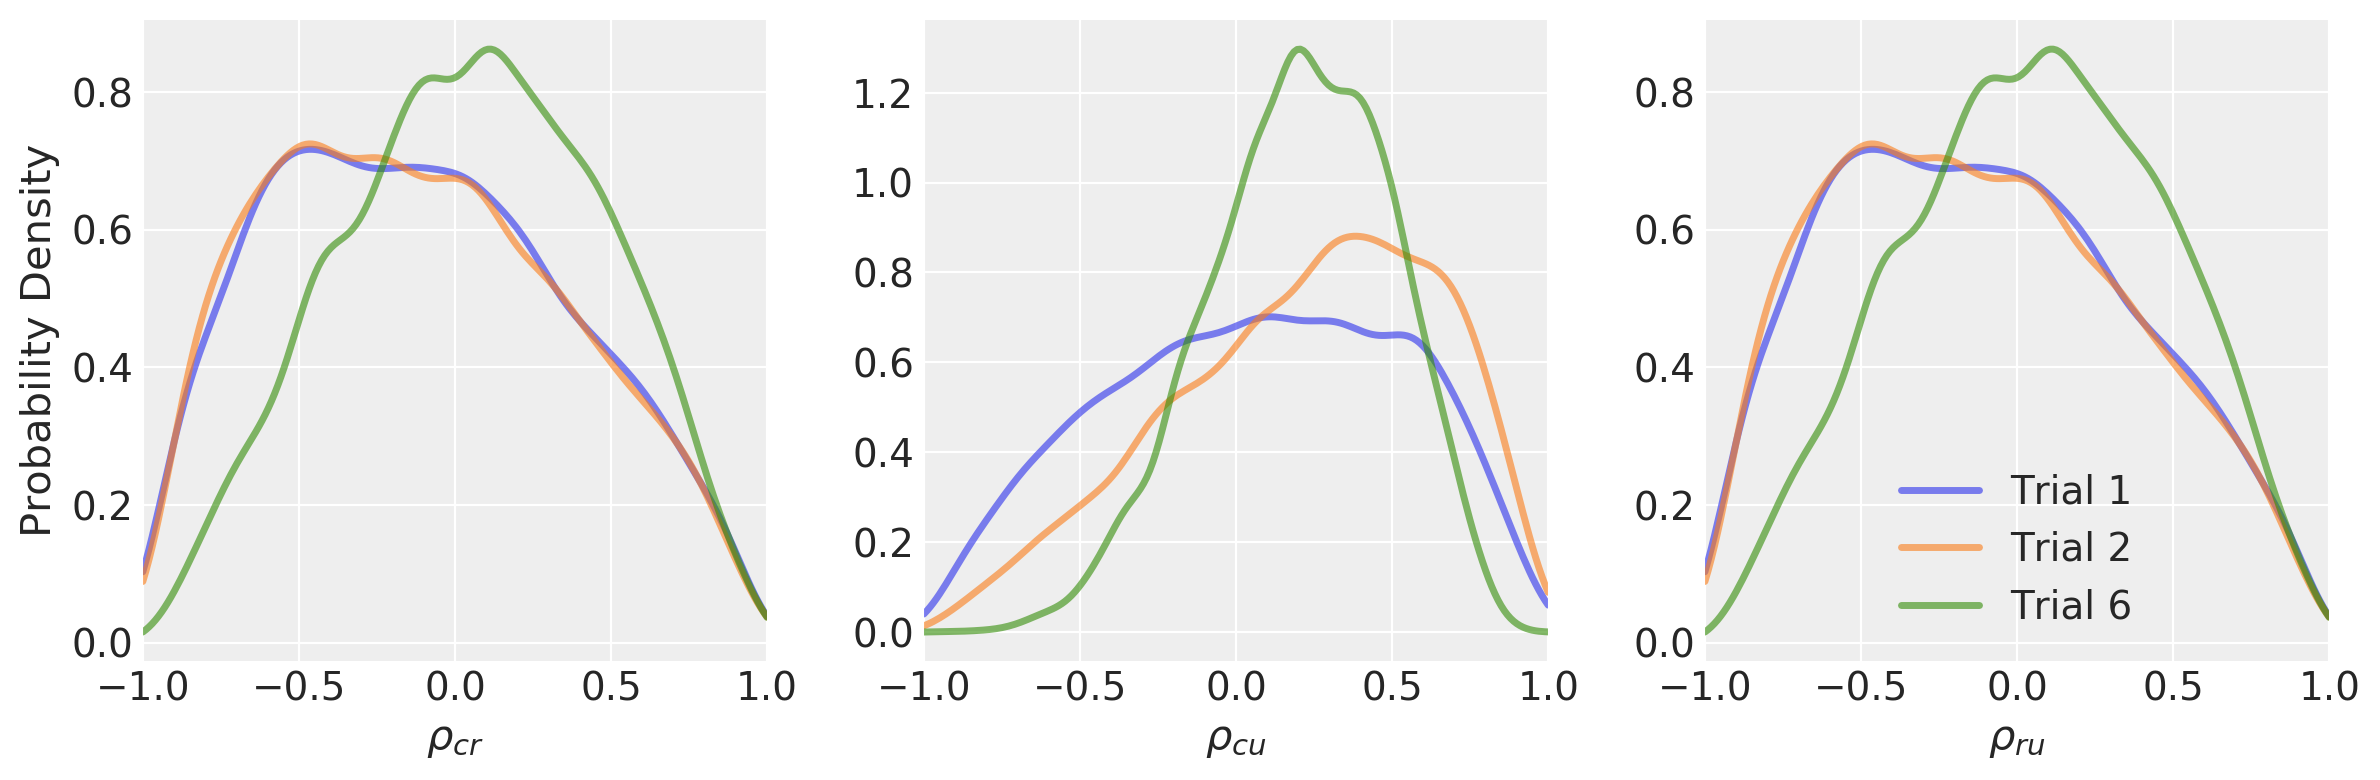

In [14]:
_, axes = plt.subplots(1, 3, figsize=(12, 4))
x1 = np.linspace(-1, 1, 200)
plotparm2 = [r"$\rho_{cr}$", r"$\rho_{cu}$", r"$\rho_{ru}$"]

for trial in np.arange(Nt):
    sigmainvpost = indiv_trial2[trial]["wishart"]
    tmpn = sigmainvpost.shape[0]
    sigmapost = np.ndarray((tmpn, 3, 3), dtype=float)
    for i in range(tmpn):
        sigmapost[i, :, :] = np.linalg.inv(sigmainvpost[i, :, :])

    cpost0 = sigmapost[:, 0, 1] / np.sqrt(sigmapost[:, 0, 0] * sigmapost[:, 1, 1])
    my_pdf = stats.kde.gaussian_kde(cpost0)
    axes[0].plot(x1, my_pdf(x1), lw=2.5, alpha=0.6)  # distribution function

    cpost1 = sigmapost[:, 0, 2] / np.sqrt(sigmapost[:, 0, 0] * sigmapost[:, 2, 2])
    my_pdf = stats.kde.gaussian_kde(cpost1)
    axes[1].plot(x1, my_pdf(x1), lw=2.5, alpha=0.6)  # distribution function

    cpost2 = sigmapost[:, 1, 2] / np.sqrt(sigmapost[:, 1, 1] * sigmapost[:, 2, 2])
    my_pdf = stats.kde.gaussian_kde(cpost0)
    axes[2].plot(x1, my_pdf(x1), lw=2.5, alpha=0.6)  # distribution function

axes[0].set_ylabel("Probability Density")
axes[0].set_xlim([-1, 1])
axes[0].set_xlabel(plotparm2[0], fontsize=15)
axes[1].set_xlim([-1, 1])
axes[1].set_xlabel(plotparm2[1], fontsize=15)
axes[2].set_xlim([-1, 1])
axes[2].set_xlabel(plotparm2[2], fontsize=15)
plt.legend(trialname)
plt.tight_layout();

The above model works fine, but using Wishart is highly discouraged, including the Wishart-Bartlett form. Below we reparameterized the model using a LKJ distribution (Cholesky decomposed version) as prior for covariance matrix.

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [vals_raw, chol_cov, xi, mu]


Sampling 4 chains for 3_000 tune and 2_000 draw iterations (12_000 + 8_000 draws total) took 108 seconds.
The number of effective samples is smaller than 25% for some parameters.


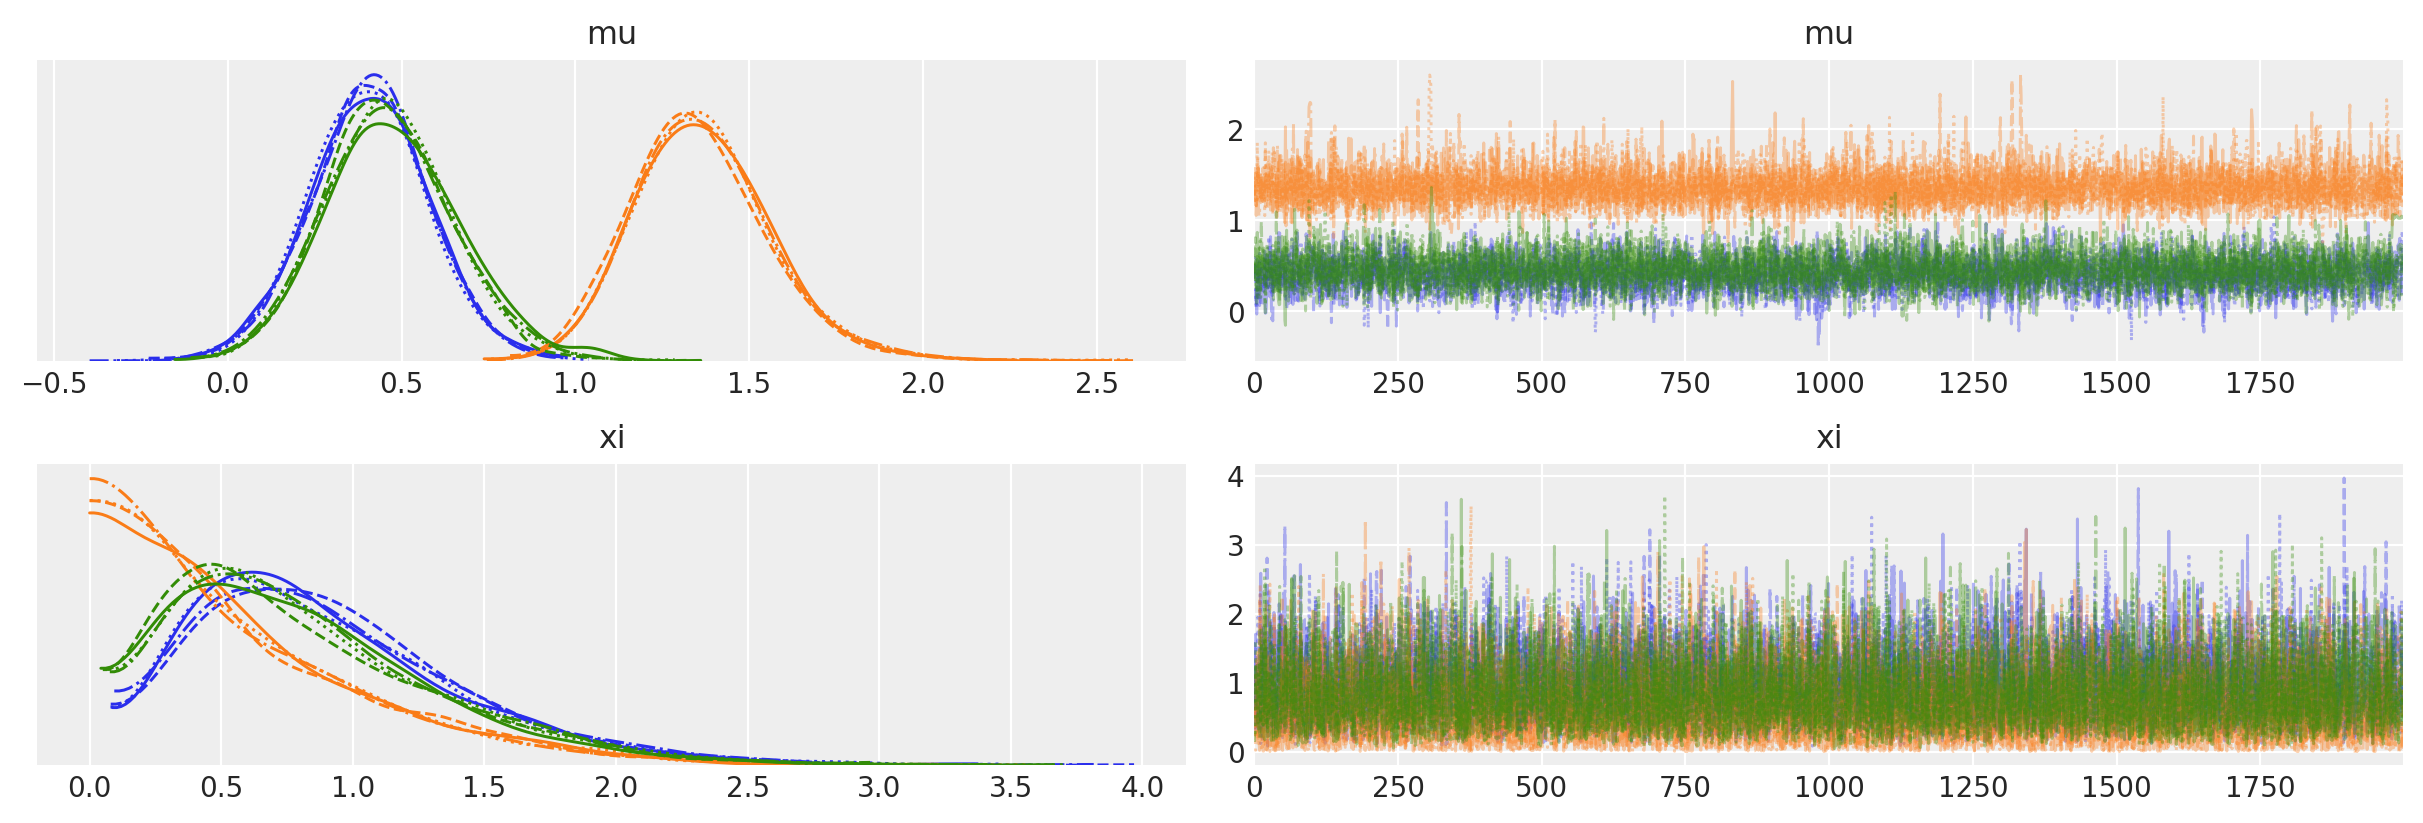

In [15]:
with pm.Model() as modelk:
    mu = pm.Normal("mu", mu=0.0, sd=1.0, shape=Nt)
    xi = pm.HalfNormal("xi", sd=1.0, shape=Nt)

    sd_dist = pm.Exponential.dist(1.0)
    packed_chol = pm.LKJCholeskyCov("chol_cov", n=Nt, eta=4, sd_dist=sd_dist)
    # compute the covariance matrix
    chol = pm.expand_packed_triangular(Nt, packed_chol, lower=True)

    vals_raw = pm.Normal("vals_raw", mu=0.0, sd=1.0, shape=(Nt, Nsubj))
    delta = tt.dot(chol, vals_raw).T

    c = Phi(mu[0] + xi[0] * delta[:, 0])
    r = Phi(mu[1] + xi[1] * delta[:, 1])
    u = Phi(mu[2] + xi[2] * delta[:, 2])

    t1 = c * r
    t2 = (1 - c) * (u ** 2)
    t3 = 2 * u * (1 - c) * (1 - u)
    t4 = c * (1 - r) + (1 - c) * (1 - u) ** 2

    muc = pm.Deterministic("muc", Phi(mu[0]))
    mur = pm.Deterministic("mur", Phi(mu[1]))
    muu = pm.Deterministic("muu", Phi(mu[2]))

    p_ = tt.stack([t1, t2, t3, t4])
    kobs = pm.Multinomial("kobs", p=p_.T, n=Nitem, observed=kall[2])
    trace = pm.sample(2000, tune=3000, init="adapt_diag", target_accept=0.95)

az.plot_trace(trace, var_names=["mu", "xi"], compact=True);

Compare with the result using wishart prior

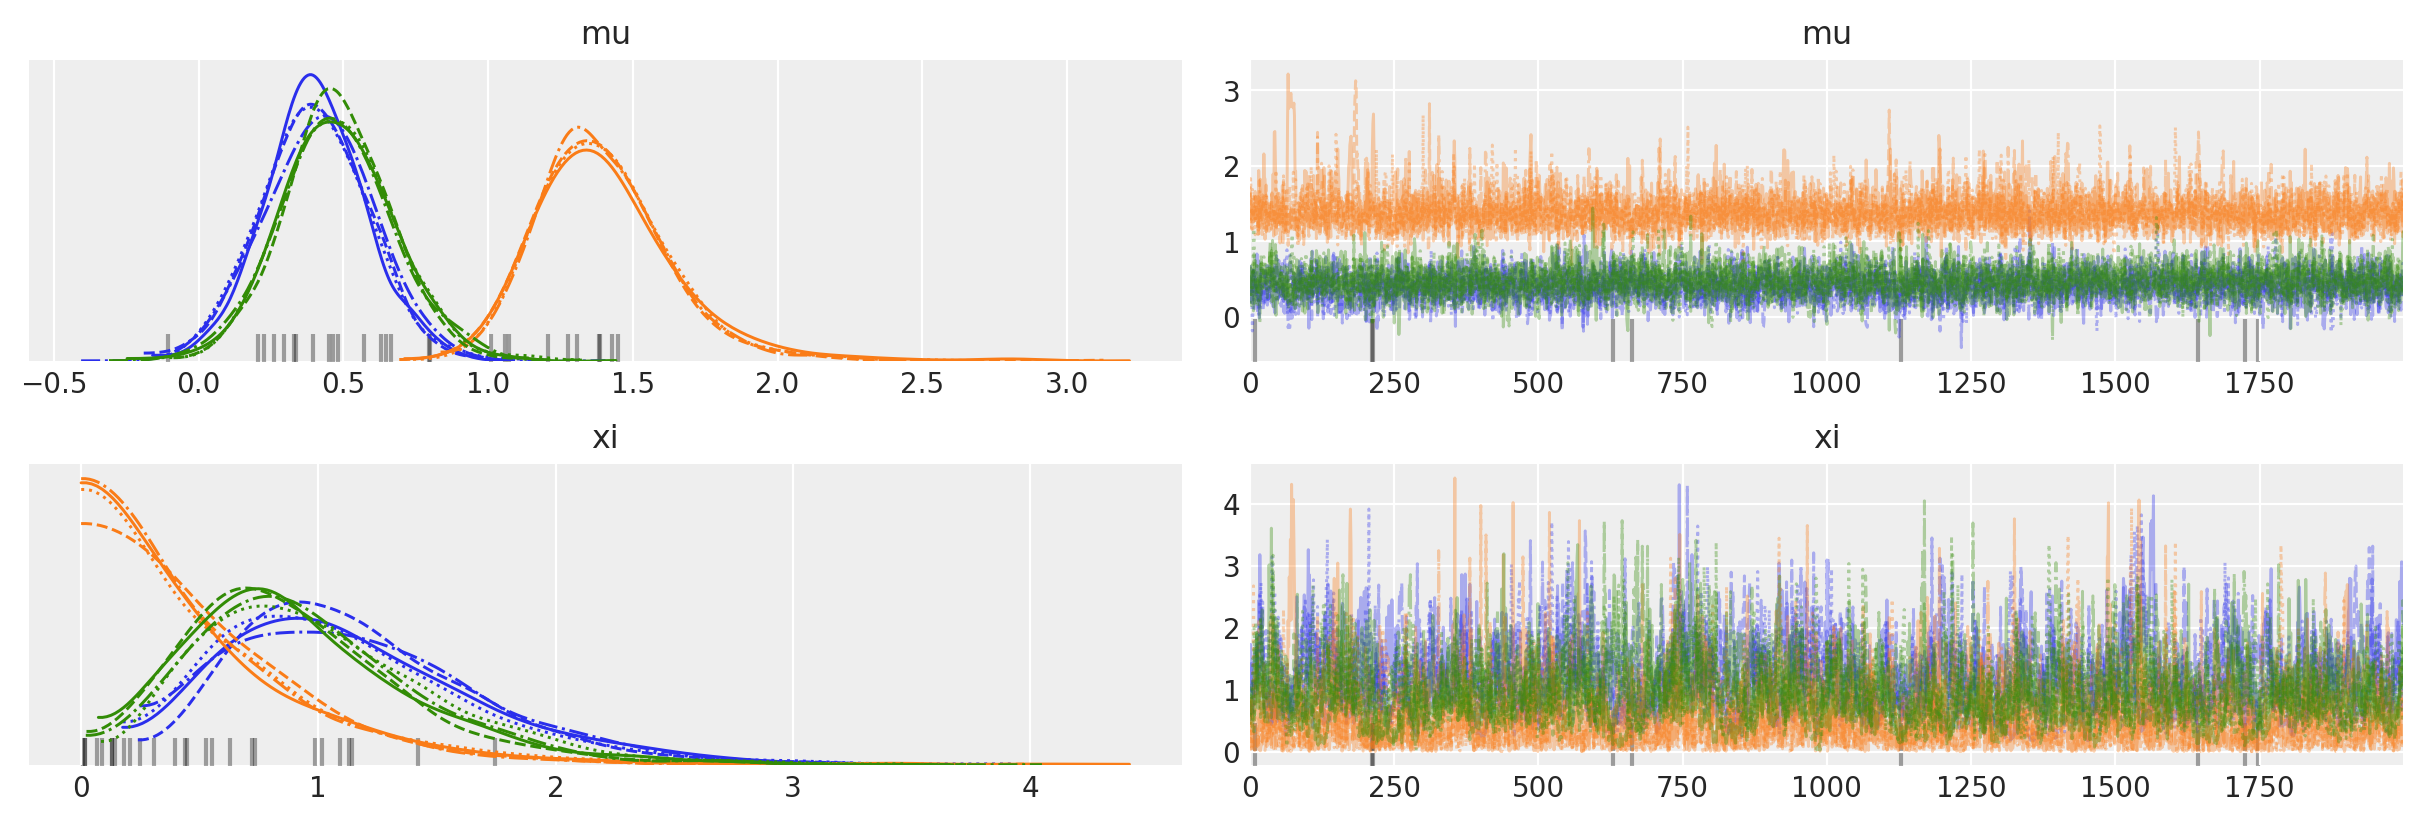

In [16]:
az.plot_trace(indiv_trial2[2], var_names=["mu", "xi"], compact=True);

In [17]:
%load_ext watermark
%watermark -n -u -v -iv -w

numpy  1.18.1
pymc3  3.8
theano 1.0.4
arviz  0.7.0
last updated: Mon Apr 27 2020 

CPython 3.7.7
IPython 7.13.0
watermark 2.0.2
